# Gestion des lits

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

## Données d'entrée

In [48]:
num_salles = 4
num_lits = 25

num_patients = 300
num_chiurgiens = 10

np.random.seed(0)

patients = pd.DataFrame({
    'id': np.arange(num_patients),
    'nom': np.random.choice(['Jean', 'Pierre', 'Paul', 'Jacques', 'Marie', 'Anne', 'Julie', 'Sophie', 'Marine', 'Marion'], size=num_patients),
    'marker': np.random.shuffle(np.arange(num_patients))
})

positions = pd.DataFrame({
    'id': np.arange(num_patients),
    'date': pd.to_datetime(19723 + np.random.randint(0, 180, size=num_patients), unit='D'),
    'patient': np.random.randint(0, 100, size=num_patients),
    'salle': np.random.randint(0, num_salles, size=num_patients),
})

operations = pd.DataFrame({
    'id': np.arange(num_patients),
    'patient': np.random.randint(0, num_patients, size=num_patients),
    'duree_op': pd.to_timedelta(np.random.normal(180*60, 30*60, size=num_patients), unit='s'),
    'duree_sspi': pd.to_timedelta(np.random.randint(5*60, 60*60, size=num_patients), unit='s'),
    'duree_sejour': pd.to_timedelta(np.random.randint(1, 10, size=num_patients), unit='D'),
    'urgence': np.random.random(num_patients) > 0.8,
    'chirurgien': np.random.randint(0, num_chiurgiens, size=num_patients),
    'date_rdv': pd.to_datetime(19723 + np.random.randint(0, 60, size=num_patients), unit='D'),
    'sejour': -1*np.ones(num_patients)
})

sejours = pd.DataFrame({
    'id': [],
    'patient': [],
    'date_entree': [],
    'date_sortie': [],
    'lit': []
})

## Optimisation

In [49]:
# Paramètres

# Ecart max entre deux séjours pour les regrouper
sejour_ecart_max = pd.to_timedelta(3, unit='D')

# Tolerance pour les urgences
tolerance_urgence = pd.to_timedelta(2, unit='D')

In [50]:
def premier_lit_dispo(sejours, date):
    """Renvoie le premier lit disponible à une date donnée."""
    if sejours.empty:
        return 0
    nb_lit = 0

    while not sejours.loc[
        (sejours['date_entree'] <= date)
        & (sejours['date_sortie'] > date)
        & (sejours['lit'] == nb_lit)
    ].empty:
        nb_lit += 1
    return nb_lit


def creer_sejour(patient, sejours, operation):
    """Crée un séjour pour un patient à partir d'une opération."""
    return {
        'id': len(sejours),
        'patient': patient['id'],
        'date_entree': operation['date_rdv'],
        'date_sortie': operation['date_rdv'] + operation['duree_sejour'],
        'lit': -1
    }


def ajuster_sejour(sejour, operation):
    """Ajuste un séjour pour un patient à partir d'une opération."""
    sejour['date_sortie'] = operation['date_rdv'] + operation['duree_sejour']
    return sejour


def ajuster_lits(sejours):
    """Ajuste les lits des séjours."""
    nouv_sejours = sejours.copy().sort_values('date_entree')
    for idx, sejour in nouv_sejours.iterrows():
        nouv_sejours.loc[idx, 'lit'] = premier_lit_dispo(nouv_sejours, sejour['date_entree'])
    return nouv_sejours


def creer_sejours(sejours, patients, operations):
    """Crée les séjours à partir des opérations."""
    nouv_sejours = sejours.copy()

    for pat_idx, patient in patients.iterrows():
        patient_operations = operations.loc[operations['patient'] == patient['id']]
        patient_operations = patient_operations.sort_values('date_rdv')
        
        for op_idx, operation in patient_operations.iterrows():
            # si le patient n'a pas de séjour, on en crée un
            if nouv_sejours.loc[nouv_sejours['patient'] == patient['id']].empty:
                nouv_sejours.loc[len(nouv_sejours)] = creer_sejour(patient, nouv_sejours, operation)
                operations.loc[op_idx, 'sejour'] = len(nouv_sejours) - 1
            else:
                # sinon on récupère le dernier séjour
                last_sejour = nouv_sejours.loc[nouv_sejours['patient'] == patient['id']].iloc[-1]
                
                if operation['date_rdv'] - last_sejour['date_sortie'] > sejour_ecart_max:
                    # si l'opération est trop loin, on crée un nouveau séjour
                    nouv_sejours.loc[len(nouv_sejours)] = creer_sejour(patient, nouv_sejours, operation)
                    operations.loc[op_idx, 'sejour'] = len(nouv_sejours) - 1
                else:
                    # sinon on ajuste le dernier séjour
                    nouv_sejours.loc[last_sejour['id']] = ajuster_sejour(last_sejour, operation)
                    operations.loc[op_idx, 'sejour'] = last_sejour['id']
    return nouv_sejours

In [51]:
sejours = creer_sejours(sejours, patients, operations).sort_values('date_entree')
sejours.head(10)

,id,patient,date_entree,date_sortie,lit
78,78,88,2024-01-01,2024-01-10,-1
136,136,143,2024-01-01,2024-01-09,-1
164,164,176,2024-01-01,2024-01-03,-1
145,145,151,2024-01-01,2024-01-07,-1
38,38,45,2024-01-02,2024-01-05,-1
62,62,72,2024-01-02,2024-01-10,-1
25,25,29,2024-01-02,2024-01-22,-1
21,21,26,2024-01-02,2024-01-10,-1
130,130,139,2024-01-02,2024-01-08,-1
36,36,43,2024-01-02,2024-01-07,-1


In [52]:
def nb_patients_sejour(sejours, date):
    """Renvoie le nombre de patients en séjour à une date donnée."""
    if sejours.empty:
        return 0
    return len(sejours.loc[(sejours['date_entree'] <= date) & (sejours['date_sortie'] > date)])
        

def nb_patients_sejours(sejours):
    """Renvoie le nombre de patients en séjour aux dates d'entrée des séjours."""
    return np.array([nb_patients_sejour(sejours, date) for date in sejours['date_entree']])

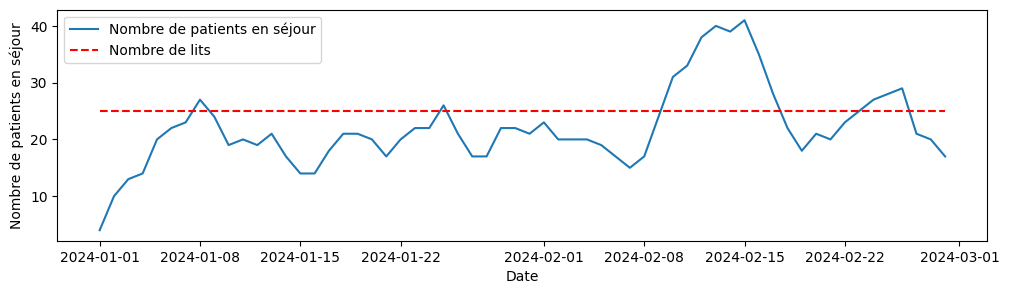

In [53]:
plt.figure(figsize=(12, 3))
plt.plot(sejours['date_entree'], nb_patients_sejours(sejours), label='Nombre de patients en séjour')
plt.hlines(num_lits, sejours['date_entree'].min(), sejours['date_entree'].max(), color='red', linestyles='dashed', label='Nombre de lits')
plt.xlabel('Date')
plt.ylabel('Nombre de patients en séjour')
plt.legend()

In [54]:
def conflits_lits(sejours):
    """Renvoie le nombre de conflits de lits."""
    return (nb_patients_sejours(sejours) - num_lits).clip(0).sum()

conflits_lits(sejours)

608

In [55]:
def conflits_urgence(sejours, operations):
    # join operations and sejours on operation index
    sejours_ = pd.merge(sejours, operations, left_on='id', right_on='sejour')
    return sejours_.loc[
        (sejours_.date_entree - sejours_.date_rdv > tolerance_urgence) &
        (sejours_.urgence == True)
    ].shape[0]

conflits_urgence(sejours, operations)

0

In [56]:
max_iter = 5000
step = np.timedelta64(1, 'D').astype('timedelta64[D]')

def calculer_conflits_lits(data):
    """Calcul le nombre de conflits de lits."""
    nb_patients = np.ones(len(data), dtype=int)

    for i in range(len(data)):
        nb_patients[
            (data[:, 0] >= data[i, 0]) &
            (data[:, 0] < data[i, 1])
        ] += 1
    
    return (nb_patients - num_lits).clip(0)

def resoudre_conflits_lits(sejours):
    """Résoud les conflits de lits."""
    data = pd.merge(
        sejours,
        operations,
        left_on='id',
        right_on='sejour',
        validate='1:m'
    ).groupby('sejour').agg({
        'sejour': 'first',
        'date_entree': 'min',
        'date_sortie': 'max',
        'date_rdv': 'min',
        'urgence': 'any'
    })

    sejours_ids = data['sejour'].to_numpy()
    dates = data[['date_entree', 'date_sortie']].to_numpy().astype('datetime64[D]')
    urgences = data['urgence'].to_numpy()

    sort_idx = np.argsort(dates[:, 0])
    sejours_ids = sejours_ids[sort_idx]
    dates = dates[sort_idx]
    urgences = urgences[sort_idx]
    
    conflits = calculer_conflits_lits(dates)
    max_conflits = conflits.max()

    i = 0

    progress = tqdm(total=max_iter)
    while max_conflits > 0 and i < max_iter:
        where = np.where((conflits > 0) & (urgences == False))[0]
        if len(where) == 0:
            break

        idx = where[0]

        dates[idx] += step

        sort_idx = np.argsort(dates[:, 0])
        sejours_ids = sejours_ids[sort_idx]
        dates = dates[sort_idx]
        urgences = urgences[sort_idx]
        conflits = calculer_conflits_lits(dates)
        max_conflits = conflits.max()

        progress.update(1)
        i += 1
    
    progress.close()

    sejours_ = sejours.copy()
    # reorder sejours
    sejours_ = sejours_.set_index('id').loc[sejours_ids].reset_index()
    sejours_['date_entree'] = dates[:, 0]
    sejours_['date_sortie'] = dates[:, 1]

    return sejours_

sejours_resolu = resoudre_conflits_lits(sejours)
sejours_resolu = ajuster_lits(sejours_resolu)

  1%|          | 50/5000 [00:00<00:10, 493.76it/s]

  7%|▋         | 370/5000 [00:00<00:09, 473.10it/s]


In [57]:
conflits_lits(sejours_resolu), conflits_urgence(sejours_resolu, operations)

(0, 0)

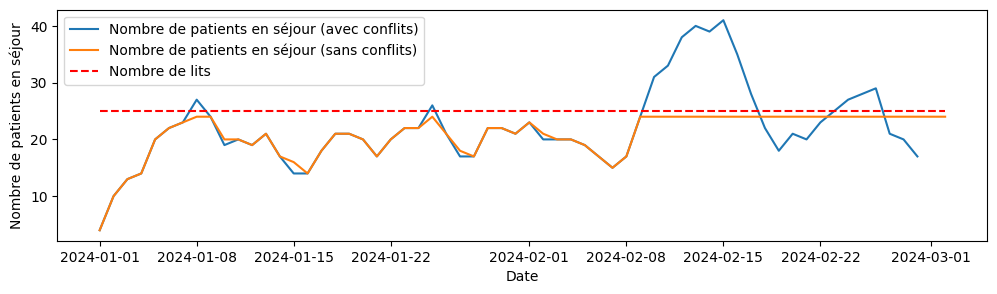

In [58]:
sejours_resolu = sejours_resolu.sort_values('date_entree')

plt.figure(figsize=(12, 3))
plt.plot(sejours['date_entree'], nb_patients_sejours(sejours), label='Nombre de patients en séjour (avec conflits)')
plt.plot(sejours_resolu['date_entree'], nb_patients_sejours(sejours_resolu), label='Nombre de patients en séjour (sans conflits)')
plt.hlines(num_lits, sejours_resolu['date_entree'].min(), sejours_resolu['date_entree'].max(), color='red', linestyles='dashed', label='Nombre de lits')

plt.xlabel('Date')
plt.ylabel('Nombre de patients en séjour')
plt.legend()

In [59]:
# px.timeline(
#     sejours,
#     x_start='date_entree',
#     x_end='date_sortie',
#     y='patient',
#     color='lit',
#     title='Planning des patients'
# )

px.timeline(
    sejours_resolu,
    x_start='date_entree',
    x_end='date_sortie',
    y='lit',
    color='patient',
    title='Planning des lits'
)

/home/codespace/.local/lib/python3.10/site-packages/_plotly_utils/basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

